In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
log_data = [
    # {
    #     "name": "TACoS-pool",
    #     "pathname": "../../log/TACoS/2D-TAN-128x128-K5L8-pool/2D-TAN-128x128-K5L8-pool_2024-01-29-14-13_.log",
    # },
    # {
    #     "name": "TACoS-conv",
    #     "pathname": "../../log/TACoS/2D-TAN-128x128-K5L8-conv/2D-TAN-128x128-K5L8-conv_2024-01-29-14-24_.log",
    # },
    {
        "name": "IAW-pool",
        "pathname": "../../log/IAW/2D-TAN-pool/2D-TAN-pool_2024-01-30-18-49_.log",
    },
    {
        "name": "IWA-conv",
        "pathname": "../../log/IAW/2D-TAN-conv/2D-TAN-conv_2024-01-30-18-49_.log",
    },
]

In [3]:
meta_reg = re.compile(r"iter: ([\d\.]+) train loss ([\d\.]+) val loss ([\d\.]+) test loss ([\d\.]+)")
table_reg = re.compile(
    r"""\+performance on (.+?) set-+\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-+\+
\| Rank@1,mIoU@0.1 \| Rank@1,mIoU@0.3 \| Rank@1,mIoU@0.5 \| Rank@1,mIoU@0.7 \| Rank@5,mIoU@0.1 \| Rank@5,mIoU@0.3 \| Rank@5,mIoU@0.5 \| Rank@5,mIoU@0.7 \| mIoU\s+\|
\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-+\+
\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|\s+([\d\.]+)\s+\|
\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-----------------\+-+\+""",
    re.MULTILINE,
)

In [4]:
for data in log_data:
    with open(data["pathname"]) as f:
        raw = f.read()
        # for result in meta_reg.findall(raw):
        #     _iter, train_loss, val_loss, test_loss = result

        epoch = 0
        epoch_data = [{}]
        for result in table_reg.findall(raw):
            stage, rank1_01, rank1_03, rank1_05, rank1_07, rank5_01, rank5_03, rank5_05, rank5_07, mIoU = result
            epoch_data[epoch].update(
                {
                    f"{stage}/rank1_01": float(rank1_01),
                    f"{stage}/rank1_03": float(rank1_03),
                    f"{stage}/rank1_05": float(rank1_05),
                    f"{stage}/rank1_07": float(rank1_07),
                    f"{stage}/rank5_01": float(rank5_01),
                    f"{stage}/rank5_03": float(rank5_03),
                    f"{stage}/rank5_05": float(rank5_05),
                    f"{stage}/rank5_07": float(rank5_07),
                    f"{stage}/mIoU": float(mIoU),
                }
            )
            if stage == "testing":
                epoch += 1
                epoch_data.append({})
        data["df"] = pd.DataFrame(epoch_data[:-1])

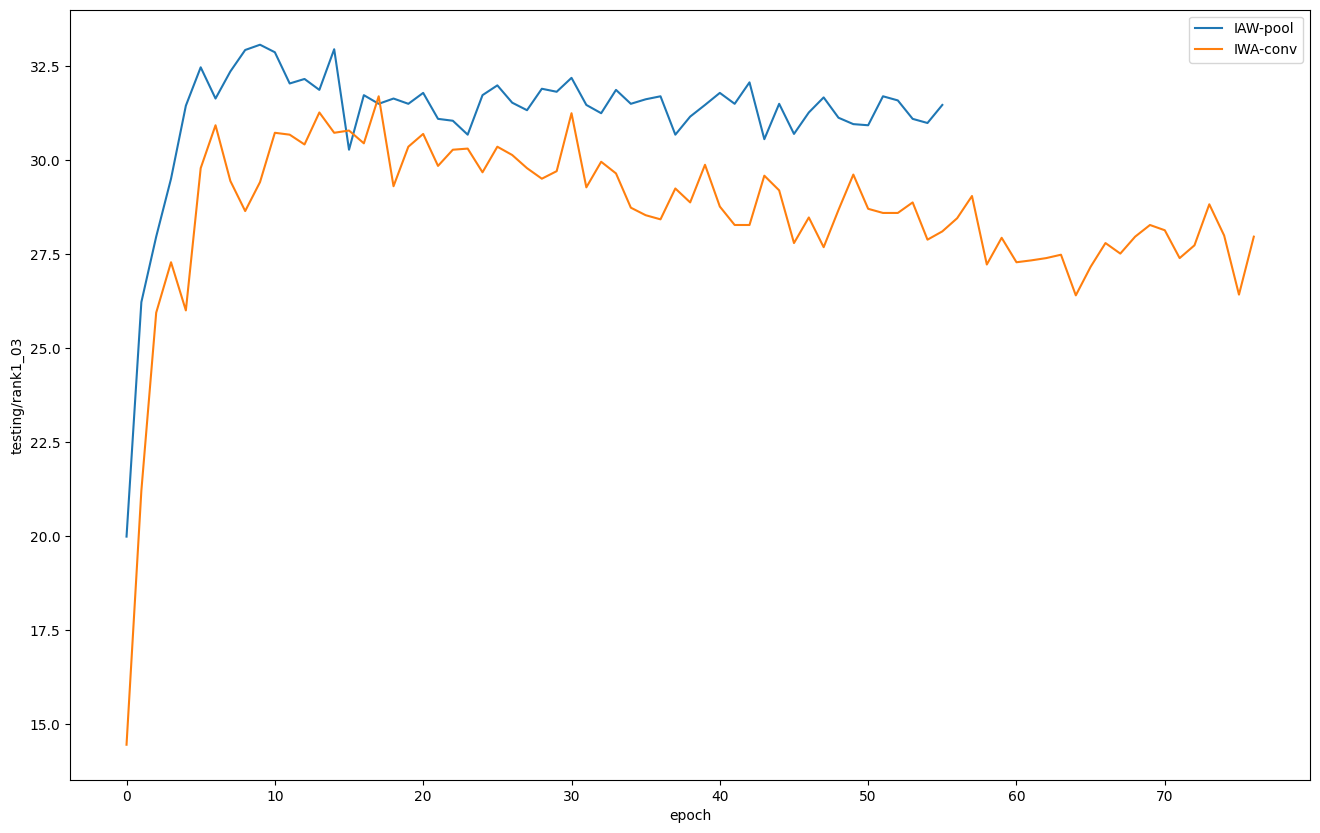

In [5]:
col = "testing/rank1_03"
# col = "testing/mIoU"
fig, ax = plt.subplots(figsize=(16, 10))
for data in log_data:
    data["df"].plot(ax=ax, y=[col], label=[data["name"]], xlabel="epoch", ylabel=col)

In [6]:
col_list = [
    {"col": "name", "title": "name"},
    {"col": "testing/rank1_03", "title": "Rank@1 IoU@0.3"},
    {"col": "testing/rank1_05", "title": "Rank@1 IoU@0.5"},
    {"col": "testing/rank1_07", "title": "Rank@1 IoU@0.7"},
    {"col": "testing/rank5_03", "title": "Rank@5 IoU@0.3"},
    {"col": "testing/rank5_05", "title": "Rank@5 IoU@0.5"},
    {"col": "testing/rank5_07", "title": "Rank@5 IoU@0.7"},
    {"col": "testing/mIoU", "title": "mIoU"},
    {"col": "epoch", "title": "epoch"},
]
table_data = []
for data in log_data:
    df = data["df"]
    row_data = [data["name"]]
    df = df.sort_values(by="testing/mIoU", ascending=False)
    for col in col_list:
        if col["col"] in df.columns:
            row_data.append(df.head(1)[col["col"]].item())
    row_data.append(df.head(1).index.item())
    table_data.append(row_data)
table_df = pd.DataFrame(table_data, columns=[col["title"] for col in col_list])
table_df

,name,Rank@1 IoU@0.3,Rank@1 IoU@0.5,Rank@1 IoU@0.7,Rank@5 IoU@0.3,Rank@5 IoU@0.5,Rank@5 IoU@0.7,mIoU,epoch
0,IAW-pool,32.94,20.02,8.17,54.33,40.63,17.77,21.21,14
1,IWA-conv,31.24,18.94,8.03,48.43,35.88,18.79,20.51,30
